In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms, utils
import torch.optim as optim
from torch.optim import lr_scheduler

import time
import os
import zipfile
from copy import deepcopy

%matplotlib inline

# vision transformer
from transformers import ViTModel, ViTConfig, ViTFeatureExtractor, ViTForImageClassification

2025-04-19 05:12:03.961258: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745039524.150679      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745039524.209314      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
torch.manual_seed(0)

In [4]:
## Custom Galaxy Zoo 2 Dataset
class GalaxyZooDataset(Dataset):
    """Galaxy Zoo Dataset"""

    def __init__(self, csv_file, images_dir, transform=None):
        """
        Args:
            csv_file (string): path to the label csv
            images_dir (string): path to the dir containing all images
            transform (callable, optional): transform to apply
        """
        self.labels_df = pd.read_csv(csv_file)
        self.labels_df = self.labels_df[['galaxyID', 'label1']].copy()

        self.images_dir = images_dir
        self.transform = transform

    def __len__(self):
        """
        Returns the size of the dataset
        """
        return len(self.labels_df)

    def __getitem__(self, idx):
        """
        Get the idx-th sample.
		Outputs the image (channel first) and the true label
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # galaxy ID
        galaxyid = self.labels_df.iloc[idx, 0].astype(str)
		# path of the image
        image_path = os.path.join(self.images_dir, galaxyid + '.jpg')
		# read the image
        image = Image.open(image_path)
		# apply transform (optional)
        if self.transform is not None:
            image = self.transform(image)
		# read the true label
        label = int(self.labels_df.iloc[idx, 1])

        return image, label, int(galaxyid)

In [5]:
def create_data_transforms(is_for_inception=False):
    """
    Create Pytorch data transforms for the GalaxyZoo datasets.
    Args:
        is_for_inception (bool): True for inception neural networks
    Outputs:
        train_transform: transform for the training data
        test_transform: transform for the testing data
    """
    if is_for_inception:
        input_size = 299
    else:
        input_size = 224

    # transforms for training data
    train_transform = transforms.Compose([transforms.CenterCrop(input_size),
                                          transforms.RandomRotation(90),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.RandomVerticalFlip(),
                                          transforms.RandomResizedCrop(input_size, scale=(0.8, 1.0), ratio=(0.99, 1.01)),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

    # transforms for validation data
    valid_transform = transforms.Compose([transforms.CenterCrop(input_size),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

    # transforms for test data
    test_transform = transforms.Compose([transforms.CenterCrop(input_size),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])


    return train_transform, valid_transform, test_transform

In [6]:
df_train = pd.read_csv('/kaggle/input/gmc-cleaned-data/data_train_cleaned.csv')
df_valid = pd.read_csv('/kaggle/input/gmc-cleaned-data/data_valid_cleaned.csv')
df_test = pd.read_csv('/kaggle/input/gmc-cleaned-data/data_test_cleaned.csv')

In [7]:
dir_image = '/kaggle/input/galaxy-zoo-2-images'

In [8]:
# create transforms
train_transform, valid_transform, test_transform = create_data_transforms(is_for_inception=False)

In [9]:
"""
Data Loader
"""
# the batch size
BATCH_SIZE = 64

# create transforms
train_transform, valid_transform, test_transform = create_data_transforms(is_for_inception=False)

# create datasets
data_train = GalaxyZooDataset('/kaggle/input/gmc-cleaned-data/data_train_cleaned.csv', '/kaggle/input/galaxy-zoo-2-images/images_gz2/images', train_transform)
data_valid = GalaxyZooDataset('/kaggle/input/gmc-cleaned-data/data_valid_cleaned.csv', '/kaggle/input/galaxy-zoo-2-images/images_gz2/images', valid_transform)
data_test = GalaxyZooDataset('/kaggle/input/gmc-cleaned-data/data_test_cleaned.csv', '/kaggle/input/galaxy-zoo-2-images/images_gz2/images', test_transform)

# dataloaders
train_loader = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(data_valid, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(data_test, batch_size=BATCH_SIZE, shuffle=True)

# check the sizes
print("**Dataloaders**")
print("Number of training data: {} ({} batches)".format(len(data_train), len(train_loader)))
print("Number of validation data: {} ({} batches)".format(len(data_valid), len(valid_loader)))
print("Number of test data: {} ({} batches)".format(len(data_test), len(test_loader)))
print("===============================")

**Dataloaders**
Number of training data: 129829 (2029 batches)
Number of validation data: 32460 (508 batches)
Number of test data: 40572 (634 batches)


In [10]:
## hyperparameter
LR = 5e-5
STEP_SIZE = 5
GAMMA = 0.1
MAX_EPOCH = 200
class_weights = torch.FloatTensor([1., 1., 1., 1., 1., 1., 1., 1.]).to(device)

## file name
model_name = "gz2_hug_vit_010822B"

## Vision Transformer
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

print("Number of trainable parameters: {}".format(sum(param.numel() for param in model.parameters() if param.requires_grad)))

# freeze the weights
#for param in model.parameters():
#    param.requires_grad = False

# change the last layer
model.classifier = nn.Linear(in_features=768, out_features=8, bias=True)

print("Number of trainable parameters: {}".format(sum(param.numel() for param in model.parameters() if param.requires_grad)))

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Number of trainable parameters: 86567656
Number of trainable parameters: 85804808


In [11]:
def train_model(model, num_epochs, criterion, optimizer, scheduler, print_every=1, early_stop_epochs=10):
    """
    Train the model
    Args:
        model: Pytorch neural model
        num_epochs: number of epochs to train
        criterion: the loss function object
        optimizer: the optimizer
        scheduler: the learning rate decay scheduler
        print_every: print the information every X epochs
        early_stop_epochs: early stopping if the model doesn't improve after X epochs
    """
    # cache the best model
    best_model_weights = deepcopy(model.state_dict())
    # best train acc
    best_train_acc = 0.0
    # best valid acc
    best_valid_acc = 0.0
    # best epoch
    best_epoch = -1

    # intiate dict to records the history of loss and acc
    history_dic = dict()
    history_dic['train_loss'] = []
    history_dic['train_acc'] = []
    history_dic['valid_loss'] = []
    history_dic['valid_acc'] = []
    history_dic['lr'] = []

    for epoch in range(num_epochs):
        # time of start
        epoch_start_time = time.time()

        """
        Train
        """
        model.train()

         # Clear GPU cache
        torch.cuda.empty_cache()

        epoch_train_cum_loss = 0.0
        epoch_train_cum_corrects = 0

        for images, labels, _ in train_loader:
            images = images.to(device)
            labels = labels.long().to(device)

            optimizer.zero_grad()

            outputs = model(images)
            pred_logits = outputs.logits
            loss = criterion(pred_logits, labels)

            _, pred_classes = torch.max(pred_logits.detach(), dim=1)
            pred_classes = pred_classes.long()

            epoch_train_cum_loss += loss.item() * images.size(0)
            epoch_train_cum_corrects += torch.sum(pred_classes==labels.data).detach().to('cpu').item()

            loss.backward()
            optimizer.step()

        """
        Eval
        """
        model.eval()

        epoch_valid_cum_loss = 0.0
        epoch_valid_cum_corrects = 0

        for images, labels, _ in valid_loader:
            images = images.to(device)
            labels = labels.long().to(device)

            with torch.no_grad():
                outputs = model(images)
                pred_logits = outputs.logits
                _, pred_classes = torch.max(pred_logits.detach(), dim=1)
                loss = criterion(pred_logits, labels)

                epoch_valid_cum_loss += loss.item() * images.size(0)
                epoch_valid_cum_corrects += torch.sum(pred_classes==labels.data).detach().to('cpu').item()

        ## Calculate metrics
        train_loss = epoch_train_cum_loss / len(data_train)
        train_acc = epoch_train_cum_corrects / len(data_train)
        valid_loss = epoch_valid_cum_loss / len(data_valid)
        valid_acc = epoch_valid_cum_corrects / len(data_valid)

        # update history_dic
        history_dic['train_loss'].append(train_loss)
        history_dic['train_acc'].append(train_acc)
        history_dic['valid_loss'].append(valid_loss)
        history_dic['valid_acc'].append(valid_acc)
        history_dic['lr'].append(scheduler.get_last_lr()[0])

        # check if is the best acc ever
        if valid_acc > best_valid_acc:
            best_train_acc = train_acc
            best_valid_acc = valid_acc
            best_epoch = epoch + 1
            # update the best model weights
            best_model_weights = deepcopy(model.state_dict())
            
        epoch_end_time = time.time()
        epoch_time_used = epoch_end_time - epoch_start_time
        # convert epoch_time_used into mm:ss
        mm = epoch_time_used // 60
        ss = epoch_time_used % 60

        ## Print metrics
        if (epoch+1) % print_every == 0:

            # if is best valid acc
            if epoch == (best_epoch - 1):
                print("Epoch {}/{}\tTrain loss: {:.4f}\tTrain acc: {:.4f}\tValid loss: {:.4f}\tValid acc: {:.4f}\tTime: {:.0f}m {:.0f}s\t<--".format(
                    epoch+1, num_epochs, train_loss, train_acc, valid_loss, valid_acc, mm, ss))
            # not a better model
            else:
                print("Epoch {}/{}\tTrain loss: {:.4f}\tTrain acc: {:.4f}\tValid loss: {:.4f}\tValid acc: {:.4f}\tTime: {:.0f}m {:.0f}s".format(
                    epoch+1, num_epochs, train_loss, train_acc, valid_loss, valid_acc, mm, ss))

        ## Early stopping
        if (epoch+1) - best_epoch >= early_stop_epochs:
            print("Early stopping... (Model did not improve after {} epochs)".format(early_stop_epochs))
            break

        scheduler.step()

    # load the best weights into the model
    model.load_state_dict(best_model_weights)
    # print the best epoch
    print("Best epoch = {}, with training accuracy = {:.4f} and validation accuracy = {:.4f}".format(best_epoch, best_train_acc, best_valid_acc))

    # return the best model
    return model, history_dic

In [12]:
# move to gpu
model = model.to(device)

# loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=LR)

# scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

## train and return the best model
model, history_dic = train_model(model, 10, criterion, optimizer, scheduler, print_every=1, early_stop_epochs=10)

## Save the best weights
torch.save(model.state_dict(), model_name + '.pth')
# torch.save(model.state_dict(), os.path.join('drive/MyDrive', model_name + '.pth'))

## Convert history to dataframe
history_df = pd.DataFrame(history_dic)

## Save the history
history_df.to_csv(model_name + '_history.csv', index=False)

Epoch 1/10	Train loss: 0.4213	Train acc: 0.8371	Valid loss: 0.3389	Valid acc: 0.8644	Time: 45m 58s	<--
Epoch 2/10	Train loss: 0.3290	Train acc: 0.8706	Valid loss: 0.3440	Valid acc: 0.8628	Time: 44m 25s
Epoch 3/10	Train loss: 0.3079	Train acc: 0.8768	Valid loss: 0.3010	Valid acc: 0.8784	Time: 44m 24s	<--
Epoch 4/10	Train loss: 0.2907	Train acc: 0.8830	Valid loss: 0.2793	Valid acc: 0.8900	Time: 44m 35s	<--
Epoch 5/10	Train loss: 0.2750	Train acc: 0.8890	Valid loss: 0.2981	Valid acc: 0.8791	Time: 44m 31s
Epoch 6/10	Train loss: 0.2250	Train acc: 0.9081	Valid loss: 0.2520	Valid acc: 0.8989	Time: 44m 28s	<--
Epoch 7/10	Train loss: 0.2128	Train acc: 0.9135	Valid loss: 0.2589	Valid acc: 0.8947	Time: 44m 25s
Epoch 8/10	Train loss: 0.2072	Train acc: 0.9156	Valid loss: 0.2527	Valid acc: 0.8989	Time: 44m 25s
Epoch 9/10	Train loss: 0.2032	Train acc: 0.9168	Valid loss: 0.2496	Valid acc: 0.9004	Time: 44m 28s	<--
Epoch 10/10	Train loss: 0.1973	Train acc: 0.9189	Valid loss: 0.2587	Valid acc: 0.8959	Tim

In [13]:
def predict_model(model):
    """
    Predict test data
    """
    # evaluation
    model.eval()

    # empty lists for results
    y_true = []
    y_pred = []
    y_label = []

    for images, labels, galaxy_id in test_loader:
        images = images.to(device)
        labels = labels.long().to(device)

        with torch.no_grad():
            outputs = model(images)
            pred_logits = outputs.logits
            _, pred_classes = torch.max(pred_logits.detach(), dim=1)

            y_true += torch.squeeze(labels.cpu()).tolist()
            y_pred += torch.squeeze(pred_classes).tolist()
            y_label += torch.squeeze(galaxy_id.cpu()).tolist()
    
    # create a DataFrame with columns 'GalaxyID', 'class', 'predicted labels'
    predict_df = pd.DataFrame(data={'GalaxyID': y_label, 'class': y_true, 'pred': y_pred})

    return y_true, y_pred, predict_df

In [14]:
# move to gpu
model = model.to(device)

# model evaluation
y_true, y_pred, predict_df = predict_model(model)

# save predict_df
predict_df.to_csv(model_name + '_predictions.csv', index=False)
# predict_df.to_csv(os.path.join('drive/MyDrive', model_name + '_predictions.csv'), index=False)

In [15]:
predict_df.head()

,GalaxyID,class,pred
0,215799,5,5
1,123375,1,1
2,140092,7,7
3,61557,1,1
4,114026,1,1


Class 0: accuracy = 0.9362 (Round Elliptical)
Class 1: accuracy = 0.9096 (In-between Elliptical)
Class 2: accuracy = 0.8536 (Cigar-shaped Elliptical)
Class 3: accuracy = 0.9110 (Edge-on Spiral)
Class 4: accuracy = 0.9054 (Barred Spiral)
Class 5: accuracy = 0.9065 (Unbarred Spiral)
Class 6: accuracy = 0.6470 (Irregular)
Class 7: accuracy = 0.7677 (Merger)
Total Accuracy = 0.8984

Recall = 0.8546

F1 score = 0.8520



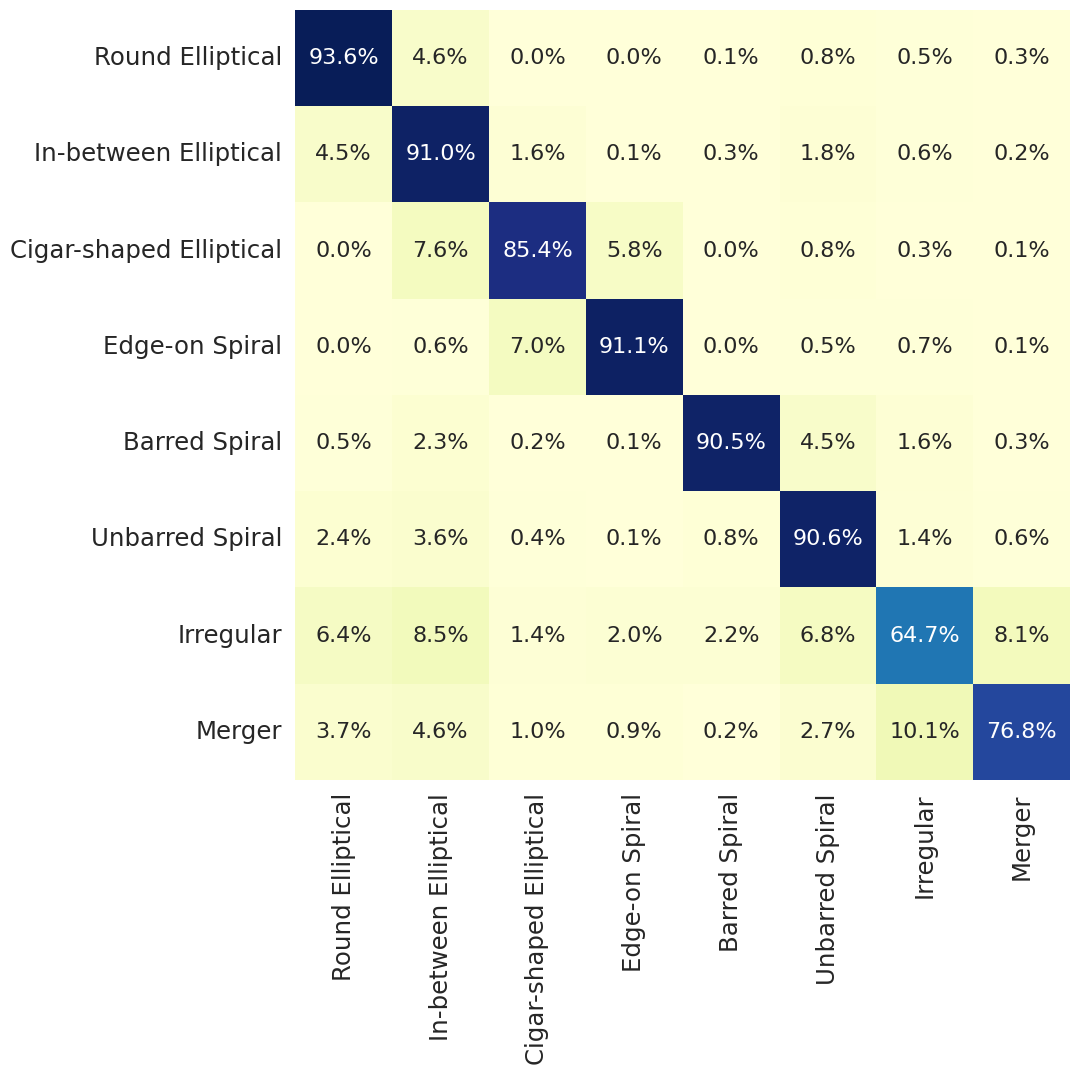

In [16]:
# galaxy classes
gxy_labels = ['Round Elliptical',
              'In-between Elliptical',
              'Cigar-shaped Elliptical',
              'Edge-on Spiral',
              'Barred Spiral',
              'Unbarred Spiral',
              'Irregular',
              'Merger']

# confusion matrix
cm = confusion_matrix(y_true, y_pred, normalize='true')
cm_df = pd.DataFrame(cm, index=gxy_labels, columns=gxy_labels)

# accuracy of each class
for c in range(8):
    print("Class {}: accuracy = {:.4f} ({})".format(c, cm[c,c]/sum(cm[c,:]), gxy_labels[c]))
print("================")

# accuracy
acc = accuracy_score(y_true, y_pred)
print("Total Accuracy = {:.4f}\n".format(acc))

# recall
recall = recall_score(y_true, y_pred, average='macro')
print("Recall = {:.4f}\n".format(recall))

# f1 score
F1 = f1_score(y_true, y_pred, average='macro')
print("F1 score = {:.4f}\n".format(F1))

# plot confusion matrix
sns.set(font_scale=1.6)
fig = plt.figure(figsize=(10, 10))
sns.heatmap(cm_df, annot=True, fmt=".1%", cmap="YlGnBu", cbar=False, annot_kws={"size": 16})
plt.show()

In [17]:
!ls -l /kaggle/working


total 335944
-rw-r--r-- 1 root root       869 Apr 19 12:38 gz2_hug_vit_010822B_history.csv
-rw-r--r-- 1 root root    430189 Apr 19 12:49 gz2_hug_vit_010822B_predictions.csv
-rw-r--r-- 1 root root 343301746 Apr 19 12:38 gz2_hug_vit_010822B.pth
---------- 1 root root    264873 Apr 19 12:49 __notebook__.ipynb
